In [1]:
import os
import sys
import numpy as np
import pandas as pd
from FTS import fts_util
from PyEMD import EMD
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
cores = sns.color_palette(n_colors=21)
warnings.filterwarnings('ignore')

## Grid Search in Alabama Time Series

In [2]:
if not os.path.isdir('out'):
    try:
        os.mkdir('out')
        print('created')
    except:
        print("don't create path out")

created


In [3]:
# read tsfcm_labels
ala = pd.read_csv('data/Enrollments.csv', sep=';', index_col=[0], parse_dates=[0])
col = ala.keys().to_list()[0]

file_results = 'out/QE_GS_Alabama.csv'

# apply EMD to get IMFs
emd = EMD()
imfs = emd.emd(ala[col].values)

''' Select MFIs without trending and noise behavior '''

df_fts = pd.DataFrame(ala[col].copy())
df_fts[col] = ala

col_imf = 'residue'
df_fts[col_imf] = imfs[1]+imfs[2]

In [4]:
from FTS.Models.MV_Lee import STFMV_Convencional_Lee
model = STFMV_Convencional_Lee()

In [5]:
for k in range(2, 22):
    # run model
    model.fit(X=df_fts[[col, col_imf]].values, k=k)
    mape, mae, mse, rmse, dtw = model.predict(plot=False, SM=False)
    
    # verify and save 
    experimento = {'IMF':col_imf, 'amount':k, 'MAPE':mape, 'MAE':mae, 'MSE':mse, 'RMSE':rmse, 'DTW':dtw}
    
    fts_util.update_values_exp(experimento, key_words=['IMF','amount', 'MSE'], fp=file_results, log=False)

In [6]:
df_view = pd.read_csv(file_results, index_col=['amount'])
df_view

,IMF,MAPE,MAE,MSE,RMSE,DTW
amount,,,,,,
2,residue,4.24,672.00,747969.04,864.85,14112.067812
3,residue,4.04,643.31,595371.47,771.60,12378.896993
4,residue,2.77,437.07,330200.68,574.63,7985.440372
5,residue,2.56,404.52,296577.48,544.59,7216.519290
6,residue,2.44,397.08,242515.60,492.46,6778.904083
7,residue,2.41,389.90,219025.42,468.00,6482.662197
8,residue,2.03,325.41,182221.61,426.87,6365.315230
9,residue,2.03,327.89,210304.09,458.59,6303.768810
10,residue,2.05,331.62,222276.53,471.46,6568.750271


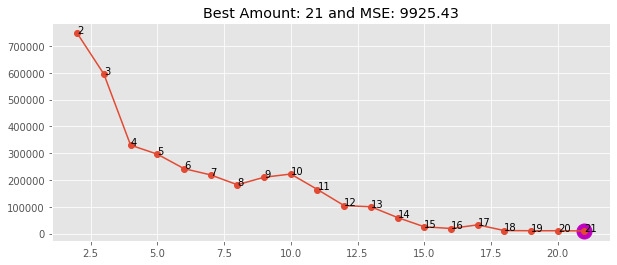

In [7]:
best = fts_util.best_GS(df_view, 'MSE')

plt.figure(figsize=(10,4))
plt.plot(best.index.values[0], best['MSE'].values[0], '-mo', markersize=15)
plt.title('Best Amount: {} and MSE: {}'.format(best.index.values[0], best['MSE'].values[0]))
plt.plot(df_view['MSE'], '-o')
for i in range(df_view.shape[0]):
    plt.annotate(df_view.index[i], (df_view.index[i], df_view['MSE'].iloc[i]))
plt.show()